## Introduction to the Interstellar Medium
### Jonathan Williams

### Figure 11.1: multi-wavelength montage of the spiral galaxy M51 (NGC 5194)

#### UV/O/IR data are from from http://dustpedia.astro.noa.gr/
#### HST Halpha data from https://archive.stsci.edu/prepds/m51/
#### VLA/Effelsberg 3cm data from https://www.mpifr-bonn.mpg.de/3168319/m51
#### VLA HI data from https://www2.mpia-hd.mpg.de/THINGS
#### IRAM CO 2-1 data from https://www2.mpia-hd.mpg.de/PAWS
#### most of the fits files are in the github repo except the very large ones (DSS_2, 2MASS_Ks, and Spitzer_24) which you have to download manually from the dustpedia website

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import PercentileInterval
from astropy.visualization import ImageNormalize
from astropy.visualization import LinearStretch, SqrtStretch, LogStretch, AsinhStretch
%matplotlib inline

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set MJD-OBS to 53121.000000 from DATE-OBS'. [astropy.wcs.wcs]
    Header size is not multiple of 2880: 1
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
invalid keyvalue. [astropy.wcs.wcs]


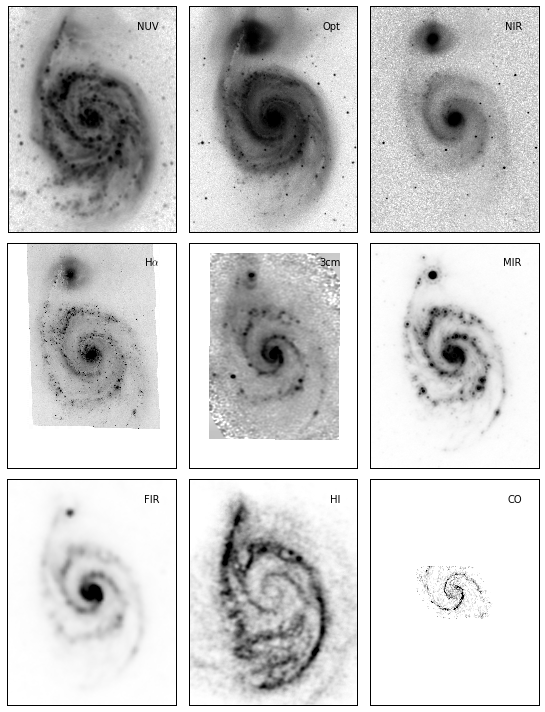

In [4]:
# SIMBAD center 13 29 52.698 +47 11 42.93
xcen, ycen = 202.469575, 47.19525833
# image size = 
xbox, ybox = 0.22, 0.20

fig = plt.figure(figsize=(7.7,10))

files = ['GALEX_NUV', 'DSS2_R', '2MASS_Ks', 'Halpha', 'VLA_3cm', 'Spitzer_24', 'SPIRE_250', 'VLA_HI_mom0', 'IRAM_CO21_mom0']
label = ['NUV', 'Opt', 'NIR', r'H$\alpha$', '3cm', 'MIR', 'FIR', 'HI', 'CO']
stretch = ['Log','Asinh','Asinh','Asinh','Asinh','Asinh','Linear','Linear','Linear']
nfiles = len(files)

# note that there are various warnings that come up due to the range of fits file headers
# (there is no standard) but these are benign so no worries...
for i in range(nfiles):
    f = files[i]
    fitsfile = 'NGC5194_'+f+'.fits'
    hdu = fits.open(fitsfile, ignore_missing_end=True)
    if 'VLA' in f:
        wcs = WCS(hdu[0].header, naxis=(1,2))
        im = hdu[0].data.squeeze()
    else:
        wcs = WCS(hdu[0].header)
        im = hdu[0].data
    hdu.close()

    # no distortion for drizzled images
    # https://docs.astropy.org/en/stable/wcs/note_sip.html
    if f=='Halpha':
        wcs.sip = None

    #print(f, im.min(), im.max())

    world = np.array([[xcen+xbox/2, ycen-ybox/2], [xcen-xbox/2, ycen+ybox/2]])
    pix = np.rint(wcs.wcs_world2pix(world, 1)).astype(int)
    position = (0.5*(pix[0,0]+pix[1,0]), 0.5*(pix[0,1]+pix[1,1]))
    size = (pix[1,1]-pix[0,1], pix[1,0]-pix[0,0])
    crop = Cutout2D(im, position=position, size=size, wcs=wcs, mode='partial')

    ax = fig.add_subplot(3, 3, i+1, projection=crop.wcs)
    if stretch[i]=='Log':
        norm = ImageNormalize(crop.data, stretch=LogStretch(), interval=PercentileInterval(99))
    elif stretch[i]=='Asinh':
        norm = ImageNormalize(crop.data, stretch=AsinhStretch(), interval=PercentileInterval(99))
    elif stretch[i]=='Sqrt':
        norm = ImageNormalize(crop.data, stretch=SqrtStretch(), interval=PercentileInterval(99))
    else:
        norm = ImageNormalize(crop.data, stretch=LinearStretch(), interval=PercentileInterval(99))
    ax.imshow(crop.data, cmap='gray_r', origin='lower', norm=norm)
    ax.text(0.9, 0.9, label[i], ha='right', transform=ax.transAxes)

    #ax.axis('off')
    for i in (0,1):
        ax.coords[i].set_ticks_visible(False)
        ax.coords[i].set_ticklabel_visible(False)
        ax.coords[i].set_ticks_visible(False)
        ax.coords[i].set_ticklabel_visible(False)
        ax.coords[i].set_axislabel('')
        ax.coords[i].set_axislabel('')

plt.tight_layout()
plt.savefig('M51_montage.pdf')